# XGBoost

In [3]:
# Installation et chargement des requirements
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             confusion_matrix, classification_report, f1_score)

# Ignorer les warnings pour la lisibilité
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


## 1 CHARGEMENT ET PREPARATION

In [4]:
df = pd.read_csv("all_expenses_profil.csv")

# Définition cible et features
y = df["profil"]
X = df.drop(["TOTEXP23", "profil", "DUPERSID", "cum_cost_share"], axis=1, errors="ignore")

# Split Train/Test (Même graine 42 pour comparaison stricte)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Sécurité pour XGBoost : s'assurer que les classes sont bien 0, 1, 2
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(f"Train set: {X_train.shape[0]} individus. Test set: {X_test.shape[0]} individus.")

Train set: 5698 individus. Test set: 1900 individus.


## 2. PIPELINE DE PRÉTRAITEMENT (Optimisé pour Arbres)

In [5]:
# Pas de Scaling nécessaire pour XGBoost.

num_vars = X.select_dtypes(include=["int64", "float64"]).columns
cat_vars = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = SimpleImputer(strategy="constant", fill_value=0)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preproc_xgb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)


## 3. MODÉLISATION ET GRID SEARCH

In [6]:
# Pipeline complet
pipe_xgb = Pipeline([
    ('preprocess', preproc_xgb),
    ('xgb', XGBClassifier(
        objective='multi:softprob', # Multiclasse avec probabilités
        num_class=3,
        eval_metric='mlogloss',
        tree_method="hist",         # Plus rapide
        random_state=42, 
        n_jobs=-1
    ))
])

# Grille d'hyperparamètres
# Note : XGBoost n'a pas de "class_weight='balanced'" simple pour le multiclasse.
# On compte sur le boosting (correction d'erreur) pour gérer les cas difficiles.
parameters_xgb = {
    'xgb__n_estimators': [100, 200],      # Nombre d'arbres (cycles de boosting)
    'xgb__max_depth': [3, 5, 7],          # Profondeur (Attention au sur-apprentissage si > 7)
    'xgb__learning_rate': [0.05, 0.1, 0.2], # Vitesse d'apprentissage (eta)
    'xgb__subsample': [0.8, 1.0],         # Fraction des données utilisées par arbre
    'xgb__colsample_bytree': [0.8, 1.0]   # Fraction des colonnes utilisées par arbre
}

print("\n--- Démarrage du Grid Search (XGBoost) ---")
print("Cela peut prendre quelques minutes...")

clf_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=parameters_xgb,
    cv=3, 
    scoring="f1_macro", # Toujours notre juge de paix
    n_jobs=-1,
    verbose=1
)

clf_xgb.fit(X_train, y_train)


--- Démarrage du Grid Search (XGBoost) ---
Cela peut prendre quelques minutes...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


,estimator,"Pipeline(step...ass=3, ...))])"
,param_grid,"{'xgb__colsample_bytree': [0.8, 1.0], 'xgb__learning_rate': [0.05, 0.1, ...], 'xgb__max_depth': [3, 5, ...], 'xgb__n_estimators': [100, 200], ...}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## 4. RÉSULTATS 


=== Résultats XGBoost ===
Meilleurs paramètres : {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Meilleur score CV (F1 Macro) : 0.3167

--- Performances sur le Test Set ---
Accuracy : 0.7921
Macro F1-Score : 0.3082

=== Classification Report ===
              precision    recall  f1-score   support

      Faible       0.80      0.99      0.88      1519
       Moyen       0.13      0.01      0.02       209
       Élevé       0.18      0.01      0.02       172

    accuracy                           0.79      1900
   macro avg       0.37      0.34      0.31      1900
weighted avg       0.67      0.79      0.71      1900



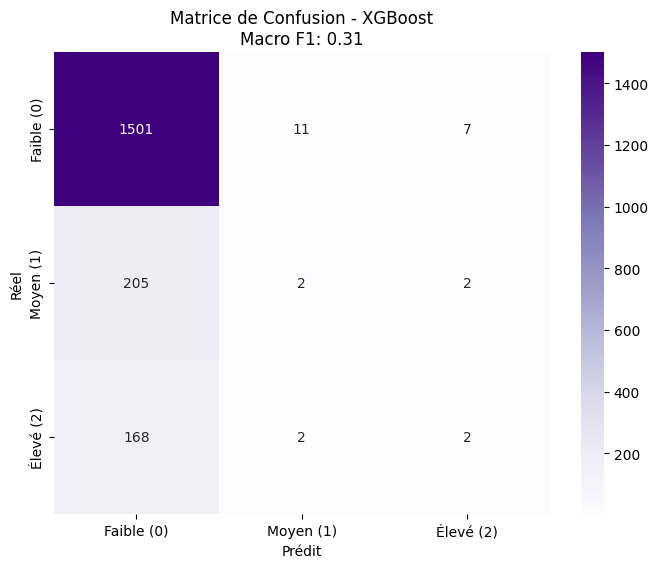

In [7]:
print("\n=== Résultats XGBoost ===")
print(f"Meilleurs paramètres : {clf_xgb.best_params_}")
print(f"Meilleur score CV (F1 Macro) : {clf_xgb.best_score_:.4f}")

# Prédictions
y_pred = clf_xgb.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
macro_f1_xgb = f1_score(y_test, y_pred, average="macro")

print("\n--- Performances sur le Test Set ---")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1-Score : {macro_f1_xgb:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Faible', 'Moyen', 'Élevé']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - XGBoost\nMacro F1: {macro_f1_xgb:.2f}')
plt.show()

## BONUS : IMPORTANCE DES VARIABLES

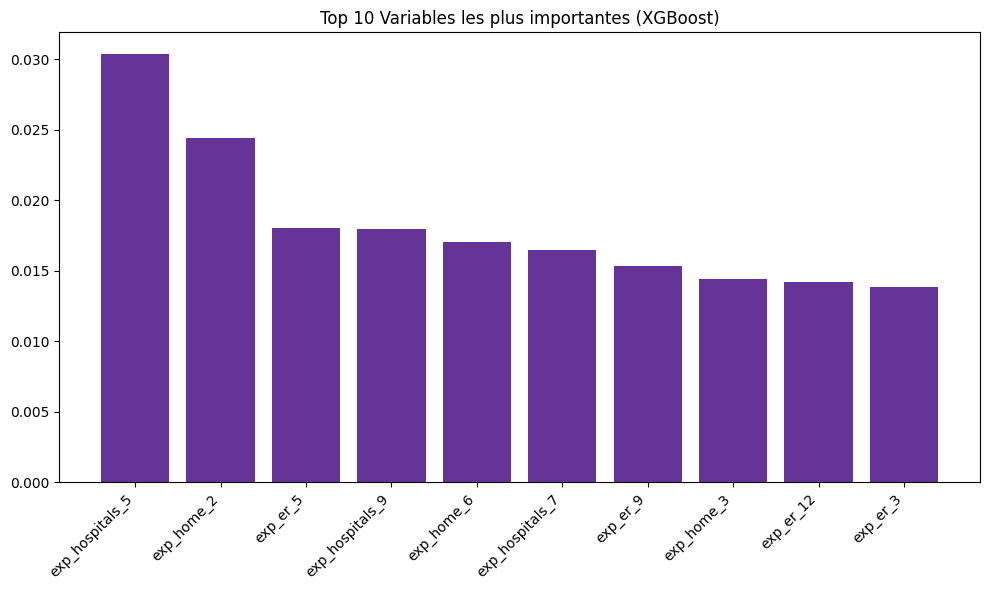

In [8]:
best_model_pipeline = clf_xgb.best_estimator_
best_xgb = best_model_pipeline.named_steps['xgb']
preprocessor = best_model_pipeline.named_steps['preprocess']

# Récupération propre des noms de features
feature_names = preprocessor.get_feature_names_out()
# Nettoyage des noms
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1][:10] # Top 10

plt.figure(figsize=(10, 6))
plt.title("Top 10 Variables les plus importantes (XGBoost)")
plt.bar(range(10), importances[indices], align="center", color='rebeccapurple')
plt.xticks(range(10), np.array(feature_names)[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()